In [1]:
# установим нужные библиотеки
import os
! pip install pymorphy2
!pip install wordcloud
!pip install natasha
!pip install transformers
import pymorphy2
import time

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_curve, auc

from sklearn.feature_extraction.text import*
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc


import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
from nltk.tag import UnigramTagger
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import re
import string
from natasha import MorphVocab, NewsEmbedding, NewsSyntaxParser, NamesExtractor, NewsMorphTagger, Doc, Segmenter, NewsNERTagger

import wordcloud
from wordcloud import WordCloud

import matplotlib
import matplotlib.pyplot as plt

import random
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel
from transformers import AdamW, get_linear_schedule_with_warmup

import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 30.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=6c0e5c2a937b489fa28910c28961135328c6b123dbe78393aef2ce598e7be9be
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26095 sha256=aa5328462e77c0dac14bba1b43198fd4a0181cf08fc3d11324edc6eb398a2dea
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
Successfully built intervaltree


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.


Задание 1

In [2]:
# Рассчитаем метрики TF-IDF для любых 10 песен на одном языке.
# Приведем слова к начальной форме, уберем стоп-слова

Загрузим датасет

In [3]:
# предварительно создали датасет по текстовкам песен, загружаем его в проект
df = pd.read_excel("songs3.xlsx", na_values = ['na',], header = 0, index_col = 0)
df

,Band,Title,Lyrics
Song,,,
1,Мельница,Ворон,"Над скалистыми хребтами, \nгде бывает снег в и..."
2,Мельница,Ночная кобыла,"Шёл ночною, порой ночною\nЗа тёмной рекою, за ..."
3,Мельница,Дракон,Позабытые стынут колодцы\nВыцвел вереск на мил...
4,Мельница,Сокол,"Я пел о богах и пел о героях, о звоне клинков ..."
5,Мельница,господин горных дорог,Закат раскинулся крестом поверх долин вершины ...
6,Мельница,Воин вереска,Над болотом туман\nВолчий вой заметает следы\n...
7,Мельница,Тамерлан,"По лазоревой степи\nХодит месяц молодой,\nС бе..."
8,Мельница,Огонь,"Я в лесах наберу слова, \nЯ огонь напою вином...."
9,Мельница,Весна,"Скошенные ветром, \nВыжженные пламенем, \nВтоп..."


In [4]:
#Посмотрим, тексты песен по количеству символов
df["Symbols"] = df["Lyrics"].apply(len)
df.head(10)

,Band,Title,Lyrics,Symbols
Song,,,,
1,Мельница,Ворон,"Над скалистыми хребтами, \nгде бывает снег в и...",1487
2,Мельница,Ночная кобыла,"Шёл ночною, порой ночною\nЗа тёмной рекою, за ...",1196
3,Мельница,Дракон,Позабытые стынут колодцы\nВыцвел вереск на мил...,923
4,Мельница,Сокол,"Я пел о богах и пел о героях, о звоне клинков ...",2167
5,Мельница,господин горных дорог,Закат раскинулся крестом поверх долин вершины ...,865
6,Мельница,Воин вереска,Над болотом туман\nВолчий вой заметает следы\n...,1089
7,Мельница,Тамерлан,"По лазоревой степи\nХодит месяц молодой,\nС бе...",827
8,Мельница,Огонь,"Я в лесах наберу слова, \nЯ огонь напою вином....",1110
9,Мельница,Весна,"Скошенные ветром, \nВыжженные пламенем, \nВтоп...",568


In [5]:
# Посмотрим, сколько всего символов у нас в десяти песнях
df["Symbols"].sum()

11540

Приступим к обработке текста песен:

In [6]:
sentences = df["Lyrics"].tolist()
sentences

['Над скалистыми хребтами, \nгде бывает снег в июле, \nнад еловыми лесами, \nчто забраться вверх рискнули, \n\nнад замшелым камнем, над ручьем, \nгде пылает солнце горячо, \n\nна потоках восходящих, \nсловно горный уголь черен, \nчерен, словно ночь незрячих, \nвидел я, как кружит ворон - \nв небесах из синего стекла \nнадо мной чернеют два крыла. \n\n\nРасскажи мне, ворон, \nрасскажи, крылатый, \nкак найти мне гору, \nчто скрывает злато, \nу какого бора, \nнад какой стремниной \nя погибну скоро \nпод камней лавиной. \n\nСкоро год, как я оставил \nгрязных городов похмелье, \nи свои стопы направил \nв эти дикие ущелья. \n\nНе распутать каменный клубок \nтем, кто не был долго одинок. \n\nЯ безумен? Ну так что же! \nНе безумнее, чем горы. \nПоздно! Думать здесь не гоже! \nНынче стану я, как ворон: \n\nВ небесах из синего стекла \nбудет нынче дважды два крыла. \n\n\nПомогите, горы, \nмне собрать все силы! \nДай перо мне, ворон, \nдля моих для крыльев, \nдай мне сил подняться \nнад скалистым

In [7]:
# Обозначим стоп-слова для русского языка из nltk
stop = stopwords.words("russian")

# обозначим небуквенные символы
nonalphanumeric = ['\'', '.', ',', '\"', ':', ';', '!', '@', '#', '$', '%', '^', '&',
                 '*', '(', ')', '-', '_', '+', '=', '[', ']', '{', '}', '\\', '?',
                 '/','>', '<', '|', ' ']

# соединим список стоп-слов для нашего случая
stop.extend(nonalphanumeric)
print(stop)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [8]:
# Применим лемматизацию для наших текстовок песен
morph = pymorphy2.MorphAnalyzer()

In [9]:
data_list = []

for text in sentences:

        text = re.sub(r'[!@#$(),n"%^*?:;~`0-9]', ' ', text) #уберем цифры и некоторые часто встречающиеся знаки
        text = re.sub(r'[^\w\s]','', text) #оставим только слова и пробелы
        text = re.sub(r'[[]]', ' ', text) #уберем скобки
        text = re.sub(r'_','',text) #убираем нижнее подчеркивание

        text = text.lower()
        data_list.append(text)

data_list

['над скалистыми хребтами  \nгде бывает снег в июле  \nнад еловыми лесами  \nчто забраться вверх рискнули  \n\nнад замшелым камнем  над ручьем  \nгде пылает солнце горячо  \n\nна потоках восходящих  \nсловно горный уголь черен  \nчерен  словно ночь незрячих  \nвидел я  как кружит ворон  \nв небесах из синего стекла \nнадо мной чернеют два крыла \n\n\nрасскажи мне  ворон  \nрасскажи  крылатый  \nкак найти мне гору  \nчто скрывает злато  \nу какого бора  \nнад какой стремниной \nя погибну скоро \nпод камней лавиной \n\nскоро год  как я оставил \nгрязных городов похмелье  \nи свои стопы направил \nв эти дикие ущелья \n\nне распутать каменный клубок \nтем  кто не был долго одинок \n\nя безумен  ну так что же  \nне безумнее  чем горы \nпоздно  думать здесь не гоже  \nнынче стану я  как ворон  \n\nв небесах из синего стекла \nбудет нынче дважды два крыла \n\n\nпомогите  горы  \nмне собрать все силы  \nдай перо мне  ворон  \nдля моих для крыльев  \nдай мне сил подняться \nнад скалистым склоно

In [10]:
emb = NewsEmbedding() # эмбеддинги
syntax_parser = NewsSyntaxParser(emb) # синтаксический парсер языка
morph_tagger = NewsMorphTagger(emb) # морфологический парсер языка
morph_vocab = MorphVocab() # объект для лемматизации
segmenter = Segmenter() # сегментация
ner_tagger = NewsNERTagger(emb) # задача распознавания именованных сущностей (NER)

In [11]:
# соберем весь текст из листа
full_text = " ".join(data_list)

# Приведем к нормальной форме
doc = Doc(full_text) # создаем объект документа Наташа
doc.segment(segmenter) # сегментация, токенизация Наташа
doc.tag_morph(morph_tagger) #морфологический обработчик

In [12]:
for token in doc.tokens:
  token.lemmatize(morph_vocab) #приведем к нормальной форме

In [13]:
full_text_cleared = [text.lemma for text in doc.tokens]
full_text_cleared

['над',
 'скалистый',
 'хребет',
 'где',
 'бывать',
 'снег',
 'в',
 'июль',
 'над',
 'еловый',
 'лес',
 'что',
 'забраться',
 'вверх',
 'рискнуть',
 'над',
 'замшелый',
 'камень',
 'над',
 'ручей',
 'где',
 'пылать',
 'солнце',
 'горячий',
 'на',
 'поток',
 'восходящий',
 'словно',
 'горный',
 'уголь',
 'черный',
 'черный',
 'словно',
 'ночь',
 'незрячий',
 'видеть',
 'я',
 'как',
 'кружить',
 'ворон',
 'в',
 'небо',
 'из',
 'синий',
 'стекло',
 'над',
 'я',
 'чернеть',
 'два',
 'крыло',
 'рассказать',
 'я',
 'ворон',
 'рассказать',
 'крылатый',
 'как',
 'найти',
 'я',
 'гора',
 'что',
 'скрывать',
 'злато',
 'у',
 'какой',
 'бор',
 'над',
 'какой',
 'стремнина',
 'я',
 'погибнуть',
 'скоро',
 'под',
 'камень',
 'лавина',
 'скоро',
 'год',
 'как',
 'я',
 'оставить',
 'грязный',
 'город',
 'похмелие',
 'и',
 'свой',
 'стопа',
 'направить',
 'в',
 'этот',
 'дикий',
 'ущелие',
 'не',
 'распутать',
 'каменный',
 'клубок',
 'тем',
 'кто',
 'не',
 'быть',
 'долго',
 'одинокий',
 'я',
 'безум

In [14]:
full_text_cleared = [text if text not in stop else "" for text in full_text_cleared]

In [15]:
words = word_tokenize(" ".join(full_text_cleared)) # разделяем на слова
words

['скалистый',
 'хребет',
 'бывать',
 'снег',
 'июль',
 'еловый',
 'лес',
 'забраться',
 'вверх',
 'рискнуть',
 'замшелый',
 'камень',
 'ручей',
 'пылать',
 'солнце',
 'горячий',
 'поток',
 'восходящий',
 'словно',
 'горный',
 'уголь',
 'черный',
 'черный',
 'словно',
 'ночь',
 'незрячий',
 'видеть',
 'кружить',
 'ворон',
 'небо',
 'синий',
 'стекло',
 'чернеть',
 'крыло',
 'рассказать',
 'ворон',
 'рассказать',
 'крылатый',
 'найти',
 'гора',
 'скрывать',
 'злато',
 'бор',
 'стремнина',
 'погибнуть',
 'скоро',
 'камень',
 'лавина',
 'скоро',
 'год',
 'оставить',
 'грязный',
 'город',
 'похмелие',
 'свой',
 'стопа',
 'направить',
 'дикий',
 'ущелие',
 'распутать',
 'каменный',
 'клубок',
 'долго',
 'одинокий',
 'безумный',
 'безумнее',
 'гора',
 'поздно',
 'думать',
 'гожий',
 'нынче',
 'стать',
 'ворон',
 'небо',
 'синий',
 'стекло',
 'нынче',
 'дважды',
 'крыло',
 'помочь',
 'гора',
 'собрать',
 'весь',
 'сила',
 'дать',
 'перо',
 'ворон',
 'крыло',
 'дать',
 'сила',
 'подняться',
 'с

In [16]:
words.remove("okcom")
words.remove("tekstypese")
words

['скалистый',
 'хребет',
 'бывать',
 'снег',
 'июль',
 'еловый',
 'лес',
 'забраться',
 'вверх',
 'рискнуть',
 'замшелый',
 'камень',
 'ручей',
 'пылать',
 'солнце',
 'горячий',
 'поток',
 'восходящий',
 'словно',
 'горный',
 'уголь',
 'черный',
 'черный',
 'словно',
 'ночь',
 'незрячий',
 'видеть',
 'кружить',
 'ворон',
 'небо',
 'синий',
 'стекло',
 'чернеть',
 'крыло',
 'рассказать',
 'ворон',
 'рассказать',
 'крылатый',
 'найти',
 'гора',
 'скрывать',
 'злато',
 'бор',
 'стремнина',
 'погибнуть',
 'скоро',
 'камень',
 'лавина',
 'скоро',
 'год',
 'оставить',
 'грязный',
 'город',
 'похмелие',
 'свой',
 'стопа',
 'направить',
 'дикий',
 'ущелие',
 'распутать',
 'каменный',
 'клубок',
 'долго',
 'одинокий',
 'безумный',
 'безумнее',
 'гора',
 'поздно',
 'думать',
 'гожий',
 'нынче',
 'стать',
 'ворон',
 'небо',
 'синий',
 'стекло',
 'нынче',
 'дважды',
 'крыло',
 'помочь',
 'гора',
 'собрать',
 'весь',
 'сила',
 'дать',
 'перо',
 'ворон',
 'крыло',
 'дать',
 'сила',
 'подняться',
 'с

In [17]:
# Посмотрим, сколько символов у нас в текстовке песен после обработки текста
len(words)

1238

In [18]:
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(words)
tfidf_vectorizer.vocabulary_

{'скалистый': 536,
 'хребет': 664,
 'бывать': 32,
 'снег': 557,
 'июль': 212,
 'еловый': 157,
 'лес': 264,
 'забраться': 168,
 'вверх': 34,
 'рискнуть': 504,
 'замшелый': 177,
 'камень': 215,
 'ручей': 513,
 'пылать': 479,
 'солнце': 565,
 'горячий': 111,
 'поток': 444,
 'восходящий': 73,
 'словно': 548,
 'горный': 109,
 'уголь': 634,
 'черный': 677,
 'ночь': 346,
 'незрячий': 332,
 'видеть': 53,
 'кружить': 247,
 'ворон': 66,
 'небо': 329,
 'синий': 534,
 'стекло': 579,
 'чернеть': 676,
 'крыло': 249,
 'рассказать': 499,
 'крылатый': 248,
 'найти': 318,
 'гора': 106,
 'скрывать': 541,
 'злато': 192,
 'бор': 25,
 'стремнина': 589,
 'погибнуть': 412,
 'скоро': 539,
 'лавина': 253,
 'год': 103,
 'оставить': 370,
 'грязный': 122,
 'город': 110,
 'похмелие': 447,
 'свой': 520,
 'стопа': 583,
 'направить': 322,
 'дикий': 136,
 'ущелие': 654,
 'распутать': 496,
 'каменный': 214,
 'клубок': 221,
 'долго': 141,
 'одинокий': 356,
 'безумный': 12,
 'безумнее': 10,
 'поздно': 423,
 'думать': 152,

In [19]:
tfidf_vectorizer.get_feature_names_out()

array(['алый', 'англия', 'ах', 'башмак', 'бегство', 'беда', 'бежать',
       'безлунный', 'безмерно', 'безопасный', 'безумнее', 'безумно',
       'безумный', 'бел', 'белый', 'берег', 'бесшумно', 'битва',
       'близкий', 'бог', 'бой', 'болото', 'боль', 'больно', 'большой',
       'бор', 'босой', 'бродить', 'брусника', 'брут', 'бук', 'буря',
       'бывать', 'быстрый', 'вверх', 'вдохнуть', 'вереск', 'верить',
       'вернуться', 'верный', 'вершина', 'весна', 'вести', 'весь',
       'ветвь', 'ветер', 'вечный', 'взглянуть', 'взмывать', 'взмывая',
       'взор', 'взять', 'видение', 'видеть', 'вино', 'властный', 'вода',
       'воздух', 'воин', 'вой', 'волна', 'волос', 'волчий', 'воля',
       'воплощение', 'ворожить', 'ворон', 'ворона', 'ворота', 'вослед',
       'воспевать', 'воспеть', 'восславить', 'восходящий', 'вплести',
       'время', 'вспоминать', 'вспомнить', 'вспыхнуть', 'втоптаные',
       'вулкан', 'выжечь', 'вызвать', 'выплакать', 'вырасти', 'вырваться',
       'высокий', 'выс

In [20]:
tfidf_df = pd.DataFrame(tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [21]:
tfidf_df

,алый,англия,ах,башмак,бегство,беда,бежать,безлунный,безмерно,безопасный,...,шаг,шелк,шептать,эней,это,южный,язык,янтарный,ясень,ясный
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# определим веса слов текстовки
weights = np.asarray(tfidf.mean(axis=0)).ravel().tolist()
weights

[0.0008077544426494346,
 0.0008077544426494346,
 0.0008077544426494346,
 0.0008077544426494346,
 0.0008077544426494346,
 0.0008077544426494346,
 0.0016155088852988692,
 0.0008077544426494346,
 0.0008077544426494346,
 0.0008077544426494346,
 0.0008077544426494346,
 0.0008077544426494346,
 0.0008077544426494346,
 0.0008077544426494346,
 0.0016155088852988692,
 0.0008077544426494346,
 0.0008077544426494346,
 0.0008077544426494346,
 0.0008077544426494346,
 0.0016155088852988692,
 0.0008077544426494346,
 0.0008077544426494346,
 0.004038772213247173,
 0.0016155088852988692,
 0.0008077544426494346,
 0.0016155088852988692,
 0.0008077544426494346,
 0.0016155088852988692,
 0.0008077544426494346,
 0.0008077544426494346,
 0.0008077544426494346,
 0.0008077544426494346,
 0.0008077544426494346,
 0.0008077544426494346,
 0.0008077544426494346,
 0.0008077544426494346,
 0.004846526655896607,
 0.0032310177705977385,
 0.002423263327948304,
 0.0008077544426494346,
 0.0008077544426494346,
 0.0072697899838449

In [23]:
# веса слов
weights_df = pd.DataFrame({'word': tfidf_vectorizer.get_feature_names_out(), "weight": weights})
weights_df

,word,weight
0,алый,0.000808
1,англия,0.000808
2,ах,0.000808
3,башмак,0.000808
4,бегство,0.000808
...,...,...
686,южный,0.000808
687,язык,0.000808
688,янтарный,0.000808
689,ясень,0.008078


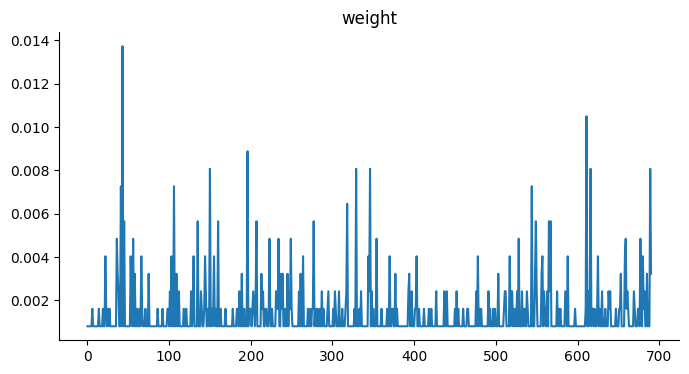

In [24]:
# @title weight

from matplotlib import pyplot as plt
weights_df['weight'].plot(kind='line', figsize=(8, 4), title='weight')
plt.gca().spines[['top', 'right']].set_visible(False)

In [25]:
# выведем наиболее встречающиеся слова
most_common_words = weights_df.sort_values(by='weight', ascending=False).reset_index().head(50)
most_common_words

,index,word,weight
0,43,весь,0.013732
1,611,твой,0.010501
2,196,знать,0.008885
3,346,ночь,0.008078
4,329,небо,0.008078
5,689,ясень,0.008078
6,616,терновник,0.008078
7,150,дуб,0.008078
8,544,след,0.007270
9,106,гора,0.007270


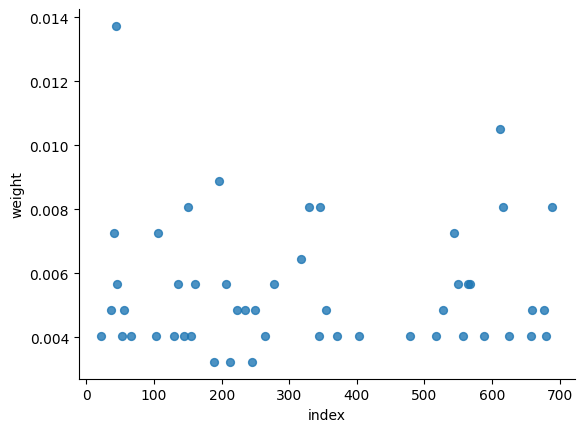

In [26]:
# @title index vs weight

from matplotlib import pyplot as plt
most_common_words.plot(kind='scatter', x='index', y='weight', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [27]:
# Посмотрим наиболее повторяющиеся слова по токенам
tokens = most_common_words['word'].to_numpy()
tokens

array(['весь', 'твой', 'знать', 'ночь', 'небо', 'ясень', 'терновник',
       'дуб', 'след', 'гора', 'весна', 'найти', 'ветер', 'ждать',
       'искать', 'солнце', 'сон', 'день', 'луна', 'слово', 'кобыла',
       'королевна', 'сердце', 'вода', 'крыло', 'вереск', 'огонь', 'холм',
       'черный', 'ночной', 'путь', 'ворон', 'видеть', 'лес', 'оставить',
       'свет', 'снег', 'трава', 'стрела', 'дать', 'чужой', 'ходить',
       'дорога', 'год', 'душа', 'платить', 'боль', 'земля', 'кровь',
       'каждый'], dtype=object)

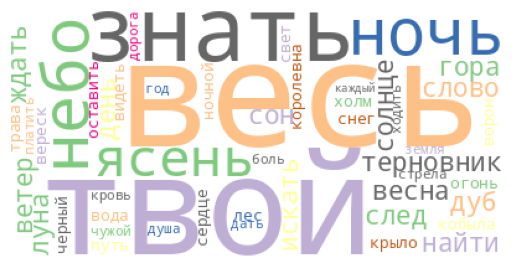

In [28]:
# Посмотрим отображение наиболее повторяющихся токенов в текстовках песен
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.subplots_adjust(wspace=0.3, hspace=0.2)

i = 1

tokens = most_common_words['word'].to_numpy()
text_raw = " ".join(tokens)
wordcloud = WordCloud(colormap='Accent', background_color='white', contour_width=10).generate(text_raw)
plt.tick_params(labelsize=10)
plt.imshow(wordcloud)
plt.axis("off")
plt.tick_params(labelsize=10)
i += 1